# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset is done in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of all appointments in all centers.

## Imports

In [1]:
import os
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
import UHCW
%matplotlib inline

Record time of beginning of script:

In [2]:
beg_script = datetime.datetime.now()

## Data
Read in the `csv` file.

In [3]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Projects/UHCW'
# filename = 'appointments.csv'
# foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Time: 23:01:31
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.52 s, sys: 190 ms, total: 2.71 s
Wall time: 2.71 s


Work with a copy, `df`, do some preprocessing.  
**Note.** The timestamp localization and conversion may take some time on a regular computer (several minutes for 5117059 records).

In [4]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
df = UHCW.prepare_UHCW_dataframe(raw_data, timezone_conversion=True)

Time: 23:01:33
CPU times: user 4min 23s, sys: 4.79 s, total: 4min 28s
Wall time: 4min 24s


## Drop column `age group` 
In `UHCW_EDA.ipynb` we have noted that each center serves exactly one age group, so we will ignore the column `age group`:

In [5]:
df.drop('age group', axis=1, inplace=True)

## List of centers with their test types

In [6]:
center_test_types = df.groupby('id')['test type'].unique().rename("test types").to_frame()
center_test_types

,test types
id,
10136,"[Fasting Bloods, Non Fasting Bloods, INR Test]"
10137,[Blood Test]
10138,[Blood Test]
10188,"[Blood Test, INR Test]"
10207,[Blood Test]
10243,"[Blood Test, INR Test]"
10244,"[Blood Test, INR Test]"
10250,"[Blood Test, INR Test]"
10254,[Blood Test]


## Generating the timegrid
We generate the `timegrid` of the dataset, that is, the full list of (`grab`, `appointment`) pairs (where `grab` does not occur after `appointment`) from the original dataset `df`.  

In [7]:
timegrid = UHCW.get_timegrid(df)
timegrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928075 entries, 0 to 930619
Data columns (total 2 columns):
grab           928075 non-null datetime64[ns, Europe/London]
appointment    928075 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2)
memory usage: 21.2+ MB


## Restricting to a smaller dataset
For **speed**, we will work on a subset of the original dataset.

In [8]:
selected_centers = [10254, 10263] #[10254] #  list(center_test_types.index)[0:5] # [10254, 10336, 10299]
df = df.loc[df['id'].apply(lambda x: x in selected_centers), :]

### Calculate history of dataset
We calculate the times of booking and cancellations of all appointments in `df`.  
*This may take a little while.*

In [9]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
df_history = UHCW.get_history(df, timegrid)

Time: 23:06:01
CPU times: user 1min 20s, sys: 2.03 s, total: 1min 22s
Wall time: 1min 21s


23:07:23
Center: 10254
Test type: Blood Test
Center: 10263
Test type: Blood Test
Test type: INR Test
CPU times: user 107 ms, sys: 4.88 ms, total: 112 ms
Wall time: 108 ms


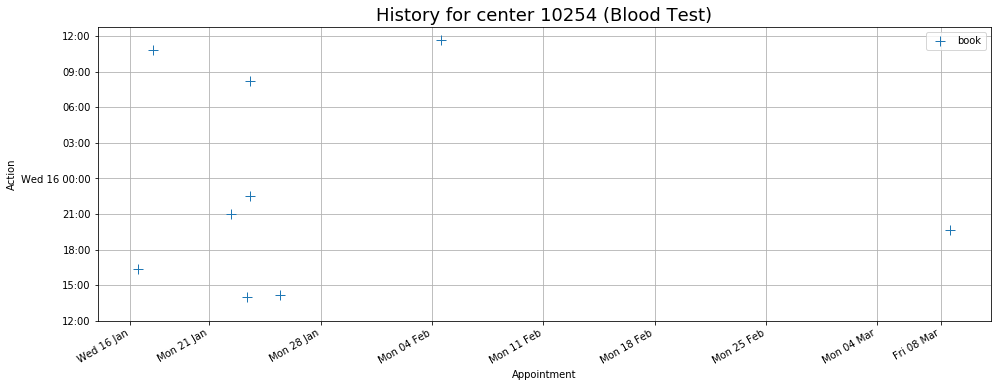

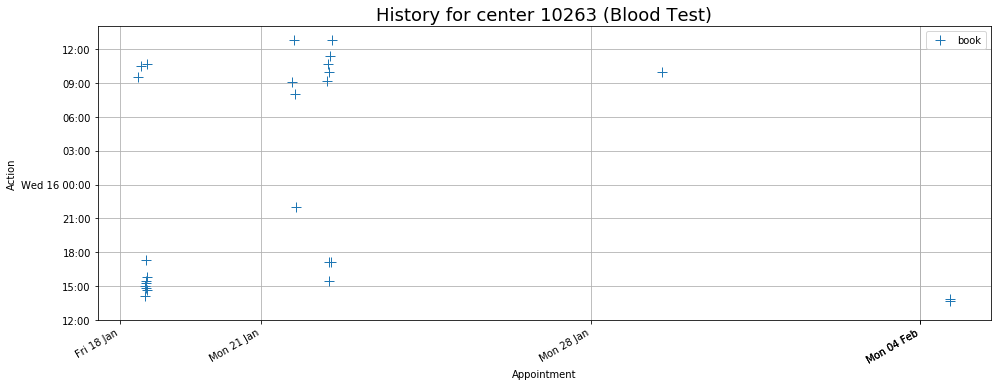

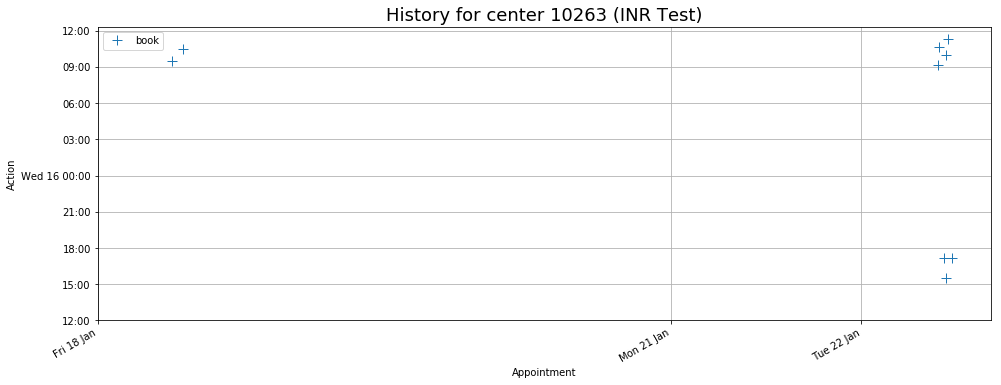

In [10]:
%%time
print(datetime.datetime.now().strftime("%H:%M:%S"))
for center_id in selected_centers:
    #break
    print("Center: {0}".format(center_id))
    for test_type in list(center_test_types.loc[center_id])[0]:
        print("Test type: {0}".format(test_type))
        df_filtered = UHCW.filter_center(df_history, center_id, test_type)
        df_filtered.iloc[0]#['id']
        UHCW.UHCW_plot(
            df_filtered.loc[:, ['id', 'test type', 'appointment', 'grab', 'action']],
            x_freq="W",
            y_freq="H",
            savefigure=False
        );

Record time of end of script:

In [11]:
end_script = datetime.datetime.now()

In [12]:
run_time = end_script - beg_script

In [13]:
print("{0}min {1}sec".format(run_time.seconds//60, run_time.seconds%60))

5min 53sec
